# Pneumonia Detection using Convolutional Neural Networks

* I started by defining the dataset's base directory and organizing it into train, val, and test subdirectories for smooth loading of data. This ensures a clear separation between training, validation, and test data.

* To understand the dataset better, I implemented a function to count the number of images in each category (NORMAL vs. PNEUMONIA). This helps verify if the dataset is balanced or if we need techniques to handle class imbalance:

In [1]:
import os

# Define base directory
base_dir = r'C:\Users\mouad\chest_xray'


# Define subdirectories for train, validation, and test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Count the number of images in each category
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(directory, "PNEUMONIA")))
    print(f"Normal: {normal_count}, Pneumonia: {pneumonia_count}")

# Inspect datasets
print("Training set:")
count_images(train_dir)
print("\nValidation set:")
count_images(val_dir)
print("\nTest set:")
count_images(test_dir)


Training set:
Normal: 1341, Pneumonia: 3875

Validation set:
Normal: 92, Pneumonia: 92

Test set:
Normal: 150, Pneumonia: 306


In the training set, there is a significant imbalance:
**1341 NORMAL vs. 3875 PNEUMONIA**
This means about 3 times more pneumonia cases than normal cases.

## Data Preprocessing 

**Image Preprocessing:**
- I set up image generators to preprocess and augment the images for the training and validation sets.
- For the training set, I applied multiple augmentations like random rotation, shift, shear, and zoom to introduce variability and prevent overfitting.
- I also normalized the pixel values to a range of [0, 1] to help the model learn efficiently.

**Validation Preprocessing:**

For the validation (and test) sets, I only rescaled the pixel values without applying augmentation to ensure we evaluate the model on real, unseen data.

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

# Set up image generators for loading and augmenting the images
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Horizontal shift
    height_shift_range=0.2, # Vertical shift
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom in/out
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill missing pixels
)

validation_datagen = ImageDataGenerator(rescale=1./255) # Only rescaling for validation and test sets

# Define base directory
base_dir = r'C:\Users\mouad\chest_xray'

# Define subdirectories for train, validation, and test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

* I used the flow_from_directory method to load the images from the directories (train, val, and test) into the model. This method automatically labels images based on the folder names (i.e., NORMAL and PNEUMONIA).
* For the training set, images are resized to 150x150 and processed in batches of 32. I also enabled shuffling to ensure randomness in the data feeding, which helps prevent overfitting.
* For the validation and test sets, images are similarly resized and batched but without shuffling since we need the order to stay consistent for evaluation.
* Since this is a binary classification task (Normal vs. Pneumonia), I used class_mode='binary', which ensures that each image is labeled either as 'Normal' (0) or 'Pneumonia' (1)

In [3]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to fit the model input
    batch_size=32,
    class_mode='binary',     # For binary classification (Normal vs Pneumonia)
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 456 images belonging to 2 classes.


### Check the loading of data

To ensure everything works properly, we can visualize some images from the train_generator:

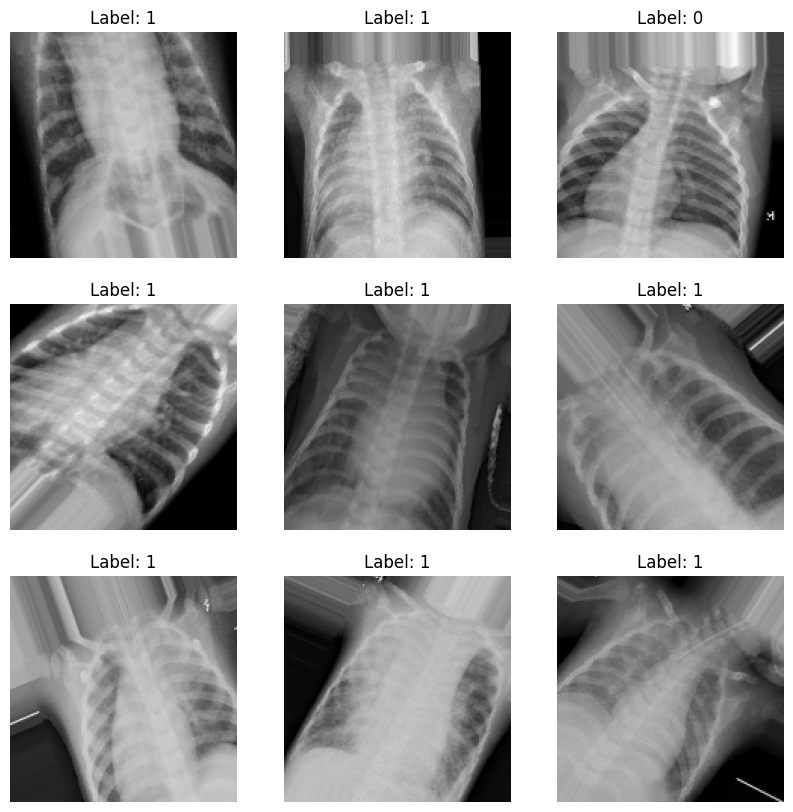

In [4]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")  # Label will be 0 or 1
    plt.axis("off")
plt.show()


## Addressing Data Imbalance


### We noticed that the training dataset is imbalanced (more Pneumonia images than Normal), which can lead to model bias. To address this, I took steps to balance the dataset.

* I first extracted all images and labels from both the training and validation generators and converted them to NumPy arrays for easier manipulation.
  
* After checking the shapes of the training and validation datasets, I ensured they were correctly formatted with the right number of samples.

* To increase the size of the validation set and create a more balanced split, I randomly moved 257 images from the training set to the validation set.
  
This helps in increasing the validation set size and ensures a fairer evaluation of the model's performance.

In [5]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Extract all images and labels from the train_generator
X_train = []
y_train = []

for i in range(len(train_generator)):
    images, labels = train_generator[i]
    X_train.append(images)
    y_train.append(labels)

# Convert lists to NumPy arrays
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Check the shape of the training data
print("X_train shape:", X_train.shape)  # Should be (num_samples, height, width, channels)
print("y_train shape:", y_train.shape)  # Should be (num_samples,)

# Step 2: Extract all images and labels from the validation_generator
X_val = []
y_val = []

for i in range(len(validation_generator)):
    images, labels = validation_generator[i]
    X_val.append(images)
    y_val.append(labels)

# Convert lists to NumPy arrays
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Check the shape of the validation data
print("X_val shape:", X_val.shape)  # Should be (num_samples, height, width, channels)
print("y_val shape:", y_val.shape)  # Should be (num_samples,)

# Step 3: Move some images from the training set to the validation set
# Set the random seed for reproducibility
np.random.seed(42)

# Number of images to move (e.g., 257 to increase validation set to 437)
num_images_to_move = 257

# Randomly select indices of images to move
indices_to_move = np.random.choice(len(X_train), num_images_to_move, replace=False)

# Move the selected images and labels from training to validation
X_val = np.concatenate([X_val, X_train[indices_to_move]])
y_val = np.concatenate([y_val, y_train[indices_to_move]])

# Remove the moved images from the training set
X_train = np.delete(X_train, indices_to_move, axis=0)
y_train = np.delete(y_train, indices_to_move, axis=0)

# Check the new sizes
print("New X_train shape:", X_train.shape)
print("New y_train shape:", y_train.shape)
print("New X_val shape:", X_val.shape)
print("New y_val shape:", y_val.shape)

X_train shape: (5216, 150, 150, 3)
y_train shape: (5216,)
X_val shape: (184, 150, 150, 3)
y_val shape: (184,)
New X_train shape: (4959, 150, 150, 3)
New y_train shape: (4959,)
New X_val shape: (441, 150, 150, 3)
New y_val shape: (441,)


## Handle the trainig set imbalance using SMOTE 

**SMOTE** (Synthetic Minority Over-sampling Technique) is a technique used to handle class imbalance in datasets. It works by generating synthetic samples for the minority class (the class with fewer samples) rather than just duplicating existing ones. This is done by taking an existing sample from the minority class and creating new instances by interpolating between the selected sample and its nearest neighbors.

By adding these synthetic examples, SMOTE helps balance the dataset, making the model less likely to be biased toward the majority class. This typically leads to improved performance, especially in classification tasks where one class dominates the other.

After flattening the images for SMOTE, I reshaped them back into their original 4D shape (num_samples, height, width, channels), ensuring the data remains compatible with the model input format.

In [6]:
# Flatten the images
num_samples, height, width, channels = X_train.shape
X_train_flat = X_train.reshape(num_samples, -1)  # Shape: (num_samples, height * width * channels)

### Apply SMOTE

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_flat_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape the flattened images back to their original shape
X_train_resampled = X_train_flat_resampled.reshape(-1, height, width, channels)

# Check the new class distribution
from collections import Counter
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({np.float32(1.0): 3682, np.float32(0.0): 1277})
Resampled class distribution: Counter({np.float32(1.0): 3682, np.float32(0.0): 3682})


**Original class distribution:**
Before applying SMOTE, we had a much larger number of pneumonia cases (3684) compared to normal cases (1275).

**Resampled class distribution:**
After applying SMOTE, the minority class (normal) was upsampled to match the number of pneumonia cases, resulting in an equal number of instances for both classes (3684 each).

In [8]:
import os
os.environ["OMP_NUM_THREADS"] = "16"  # Use 16 threads to speed things up
os.environ["TF_NUM_INTEROP_THREADS"] = "16"
os.environ["TF_NUM_INTRAOP_THREADS"] = "16"

*Load Pre-trained Model: The ResNet50 model, pre-trained on ImageNet, is loaded without the top layers (fully connected layers) to use it as a feature extractor. The input shape is defined based on the dataset dimensions.

*Add Custom Layers: Custom layers are added on top of the ResNet50 base model:

*GlobalAveragePooling2D reduces dimensionality.

*A Dense layer with 1024 neurons and ReLU activation captures complex patterns.

*A final Dense layer with 1 neuron and sigmoid activation provides a binary classification output.

*Model Compilation: The model is compiled using the Adam optimizer with a learning rate of 0.0001. Binary cross-entropy loss is used for binary classification, and the model tracks performance metrics like accuracy, Precision, Recall, and AUC.

*Training: The model is trained on resampled data (with SMOTE applied to address class imbalance) for 10 epochs, using a batch size of 32, with validation data for monitoring performance during training.

In [9]:
import numpy as np
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Load a pretrained model ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, channels))

# Add custom layers on top of the pretrained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Single neuron for binary classification

# Combine the base model and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy',Precision(), Recall(), AUC()])

# Train the model on the resampled data
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 972s 4s/step - accuracy: 0.9150 - auc: 0.9646 - loss: 0.2158 - precision: 0.9242 - recall: 0.9057 - val_accuracy: 0.6463 - val_auc: 0.6960 - val_loss: 1.1323 - val_precision: 0.6463 - val_recall: 1.0000
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 715s 3s/step - accuracy: 0.9898 - auc: 0.9995 - loss: 0.0303 - precision: 0.9905 - recall: 0.9896 - val_accuracy: 0.6463 - val_auc: 0.6636 - val_loss: 1.7584 - val_precision: 0.6463 - val_recall: 1.0000
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.9933 - auc: 0.9989 - loss: 0.0246 - precision: 0.9944 - recall: 0.9919 - val_accuracy: 0.6463 - val_auc: 0.4516 - val_loss: 2.3058 - val_precision: 0.6463 - val_recall: 1.0000
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.9944 - auc: 0.9997 - loss: 0.0168 - precision: 0.9937 - recall: 0.9950 - val_accuracy: 0.7098 - val_auc: 0.8654 - val_loss: 1.2395 - val_precision: 0.6910 - val_recall: 0.9965
Epoch 5/10
231/231 ━━━━━━━━━

In [10]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator)
print(test_results)
# Extract the results
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_auc = test_results[4]

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

C:\Users\mouad\SDS-CP021-pneumonia-detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - accuracy: 0.8052 - auc: 0.6800 - loss: 1.4264 - precision: 0.5432 - recall: 0.7289             
[0.8968683481216431, 0.8859649300575256, 0.8735294342041016, 0.970588207244873, 0.9060131311416626]
Test Loss: 0.8968683481216431
Test Accuracy: 0.8859649300575256
Test Precision: 0.8735294342041016
Test Recall: 0.970588207244873
Test AUC: 0.9060131311416626


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Train initial model
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[lr_scheduler])

# Unfreeze some deeper layers for fine-tuning
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train again with fine-tuning
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[lr_scheduler])

Epoch 1/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.0019 - precision: 0.9994 - recall: 0.9993 - val_accuracy: 0.9274 - val_auc: 0.9568 - val_loss: 0.3570 - val_precision: 0.9203 - val_recall: 0.9719 - learning_rate: 1.0000e-04
Epoch 2/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0011 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.8821 - val_auc: 0.9287 - val_loss: 0.6679 - val_precision: 0.8722 - val_recall: 0.9579 - learning_rate: 1.0000e-04
Epoch 3/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 896s 4s/step - accuracy: 0.9983 - auc: 0.9999 - loss: 0.0064 - precision: 0.9993 - recall: 0.9972 - val_accuracy: 0.9138 - val_auc: 0.9435 - val_loss: 0.5054 - val_precision: 0.9158 - val_recall: 0.9544 - learning_rate: 1.0000e-04
Epoch 4/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 931s 4s/step - accuracy: 0.9961 - auc: 0.9998 - loss: 0.0148 - precision: 0.9965 - recall: 0.9957 - val_accuracy: 0.9342 - val_auc: 0.9727 - val_loss: 

In [12]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator)
print(test_results)
# Extract the results
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_auc = test_results[4]

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.8877 - auc_1: 0.6884 - loss: 1.3627 - precision_1: 0.6005 - recall_1: 0.7205             
[0.9763229489326477, 0.9188596606254578, 0.9216300845146179, 0.9607843160629272, 0.9170478582382202]
Test Loss: 0.9763229489326477
Test Accuracy: 0.9188596606254578
Test Precision: 0.9216300845146179
Test Recall: 0.9607843160629272
Test AUC: 0.9170478582382202


We froze the layers of ResNet50 to prevent them from being updated during the first phase of training, allowing the model to focus on learning from the custom layers while retaining the pre-learned features from ImageNet.

After some initial training, we unfroze the last 50 layers of the base model to fine-tune them, allowing the model to better adapt to our specific task.

We recompiled the model with a smaller learning rate to prevent large weight changes, and we continued training the model with the resampled data.

We used key metrics like accuracy, precision, recall, and AUC to evaluate performance. 

In [14]:
model.save("tuned_resnet50_model.h5")  # Saves as an HDF5 file


In [15]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enables compression
tflite_model = converter.convert()

# Save the compressed model
with open("tuned_resnet50_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\mouad\AppData\Local\Temp\tmp2811ritm\assets


INFO:tensorflow:Assets written to: C:\Users\mouad\AppData\Local\Temp\tmp2811ritm\assets


Saved artifact at 'C:\Users\mouad\AppData\Local\Temp\tmp2811ritm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2470672071696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470672064304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470672367856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470672371904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470672369616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470672370672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470672379120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470672382992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470143561216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2470143558224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  24701